In [4]:
import numpy as np
import pandas as pd
import torch
from NashAgent_lib import *
from RAT_env import *
from NashRL import *
import matplotlib.pyplot as plt
from collections import Counter
from heuristic import run_heuristic

def predict_action(nn,states):
    if len(states.shape) > 2:
        B, A, D = states.shape  # B = batch size (10), A = agents (3), D = 255
        flat_states = states.view(B * A, D)  # Flatten to shape (30, 255)
        # Forward pass through action_net
        action_list = nn.forward(input=flat_states)
        # Reshape back to (10, 3, -1)
        action_list = action_list.view(B, A, -1)
        return action_list
    else:
        action_list = nn.forward(input=states) 

        return action_list

def evaluate_action_network(rat_env, action_network, n_episodes):
    
    action_network.eval()

    reward_buffer = []
    action_buffer = []
    for i in range(n_episodes):
        rat_env.reset()
        for t in range(0, 30):
            current_state, _, _ = rat_env.get_state()
            state = expand_list(current_state, rat_env.n_users)
            actions = torch.argmax(predict_action(action_network, state[:, :rat_env.n_stations]), dim=1)
            _, _, _, reward = rat_env.step(actions.detach())
            
            action_buffer.append(actions)
            reward_buffer.append(reward)
    
    return reward_buffer, action_buffer




def plot_reward(reward_buffer):
    n_runs = len(reward_buffer)
    n_agents = len(reward_buffer[0])
    
    fig, axes = plt.subplots(2, 5, figsize=(8, 12))

    for i in range(n_agents):
        ax = axes[i // 5, i % 5]
        agent_rewards = np.array([reward_buffer[run][i] for run in range(n_runs)])
        
        ax.plot(range(n_runs), agent_rewards, label=f"User {i+1}")

        ax.set_title(f"User {i+1}")
        ax.set_xlabel("Step")
        ax.set_ylabel("Reward")
        ax.grid(True)
        ax.legend()

    fig.suptitle("Reward Evolution for Each User Across Runs", fontsize=16)
    plt.tight_layout()
    plt.show()

def plot_actions(actions_buffer):
    n_runs = len(actions_buffer)
    n_agents = len(actions_buffer[0])
    
    fig, axes = plt.subplots(2, 5, figsize=(8, 12))

    for i in range(n_agents):
        ax = axes[i // 5, i % 5]
        agent_actions = np.array([int(torch.round(actions_buffer[run][i])) for run in range(n_runs)])
        ax.plot(range(n_runs), agent_actions, label=f"Agent {i+1}")

        ax.set_title(f"User {i+1}")
        ax.set_xlabel("Step")
        ax.set_ylabel("Station chosen")
        ax.grid(True)
        ax.legend()

    fig.suptitle("Stations Chosen by Each User Across Runs", fontsize=16)
    plt.tight_layout()
    plt.show()

def print_stats(rewards, actions,n_users):
    APs_chosen = [value.item() for action in actions for value in action if value.item() > 3]
    counted_aps = Counter(APs_chosen)
    LTEs_chosen = [value.item() for action in actions for value in action if value.item() <= 3]
    counted_ltes = Counter(LTEs_chosen)
    average_LTE_reward = np.mean([reward for reward, action in zip(rewards, actions) if any(value.item() <= 3 for value in action)])
    average_AP_reward = np.mean([reward for reward, action in zip(rewards, actions) if any(value.item() > 3 for value in action)])
    all_rewards = torch.cat(rewards).numpy()
    total_sn_chosen =  len(APs_chosen) + len(LTEs_chosen)
    disconnections = np.sum(all_rewards < 0)

    print(f"TEST RESULTS with {n_users} users in 150 episodes ({total_sn_chosen} stations chosen)")
    print("-----------------------------------------")
    print(f"{len(counted_aps)} APs chosen {len(APs_chosen)} times ({100 * len(APs_chosen) / (len(APs_chosen) + len(LTEs_chosen)):.2f}%) | {len(counted_ltes)} LTEs chosen {len(LTEs_chosen)} times ({100 * len(LTEs_chosen) / (len(APs_chosen) + len(LTEs_chosen)):.2f}%)")
    print(f"User disconnected {disconnections} times ({(disconnections / total_sn_chosen):.5f} %)")
    print(f"Average reward in LTEs: {average_LTE_reward:.3f} --> {average_LTE_reward * 600:.3f} Mb/s")
    print(f"Average reward in APs: {average_AP_reward:.3f} --> {average_AP_reward * 600:.3f} Mb/s")
    print("-----------------------------------------")
    print(f"LTEs chosen :", counted_ltes)
    print(f"APs chosen :", counted_aps)



Initialize enviroment

In [5]:
# Parameters for the Multi-RAT Network
area_width = 150
n_aps = 9
n_users = 10
n_steps = 30
rat_env = Multi_RAT_Network(area_width, n_users, n_aps, n_steps, plot=False)

### Evaluate DQN

In [9]:
action_network = PermInvariantQNN(n_users = rat_env.n_users, n_stations = rat_env.n_stations, out_dim= rat_env.n_stations, lat_dims=512, layers=1)
action_network.load_state_dict(torch.load("Action_Net.pt"))
rewards,actions = evaluate_action_network(rat_env, action_network, n_episodes = 150)
print_stats(rewards, actions, n_users)


C:\Users\alvar\AppData\Local\Temp\ipykernel_20780\1665654982.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  action_network.load_state_dict(torch.load("Action_Net.pt"))


TEST RESULTS with 10 users in 150 episodes (45000 stations chosen)
-----------------------------------------
9 APs chosen 39276 times (87.28%) | 4 LTEs chosen 5724 times (12.72%)
User disconnected 0 times (0.00000 %)
Average reward in LTEs: 0.425 --> 255.071 Mb/s
Average reward in APs: 0.434 --> 260.618 Mb/s
-----------------------------------------
LTEs chosen : Counter({0: 3421, 3: 952, 2: 933, 1: 418})
APs chosen : Counter({11: 5468, 8: 5249, 5: 4369, 9: 4337, 6: 4197, 12: 4069, 7: 4050, 4: 3900, 10: 3637})


TEST RESULTS with 10 users in 150 episodes (45000 stations chosen)
9 APs chosen 37358 times (83.02%) | 4 LTEs chosen 7642 times (16.98%)
User disconnected 0 times (0.00000 %)
Average reward in LTEs: 0.408 --> 244.890 Mb/s
Average reward in APs: 0.415 --> 249.239 Mb/

Let's try tunning the hyperparameters to make it better, first gamma from 0.99 to 0.97 to 0.95

With 0.97 I would say it has improved:

TEST RESULTS with 10 users in 150 episodes (45000 stations chosen)
9 APs chosen 39479 times (87.73%) | 4 LTEs chosen 5521 times (12.27%)
User disconnected 0 times (0.00000 %)
Average reward in LTEs: 0.424 --> 254.645 Mb/s
Average reward in APs: 0.432 --> 259.291 Mb/s

Let's go with 0.95

### Evaluate Heuristic algorithm

In [3]:
# Simuation parameters
n_episodes = 150
h_value = 1
p_switch = 0.8
m = 0
h_rewards, h_actions = run_heuristic(rat_env, n_episodes, h_value, p_switch, m)
print_stats(h_rewards, h_actions, n_users)


Simulaton progess:   0%|          | 0/150 [00:00<?, ?it/s]c:\Users\alvar\Documents\TELECO\cuarto\Thesis\Nash_DQN_RAT\heuristic.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewards_buffer.append(torch.tensor(lr))
Simulaton progess: 100%|██████████| 150/150 [00:31<00:00,  4.80it/s]


TEST RESULTS with 10 users in 150 episodes (45000 stations chosen)
-----------------------------------------
9 APs chosen 36541 times (81.20%) | 4 LTEs chosen 8459 times (18.80%)
User disconnected 244 times (0.00542 %)
Average reward in LTEs: 0.444 --> 266.199 Mb/s
Average reward in APs: 0.447 --> 268.080 Mb/s
-----------------------------------------
LTEs chosen : Counter({0: 2437, 3: 2148, 2: 2043, 1: 1831})
APs chosen : Counter({8: 4668, 11: 4294, 7: 4241, 9: 4187, 12: 4116, 5: 4016, 6: 3965, 10: 3614, 4: 3440})


### Plot the different results

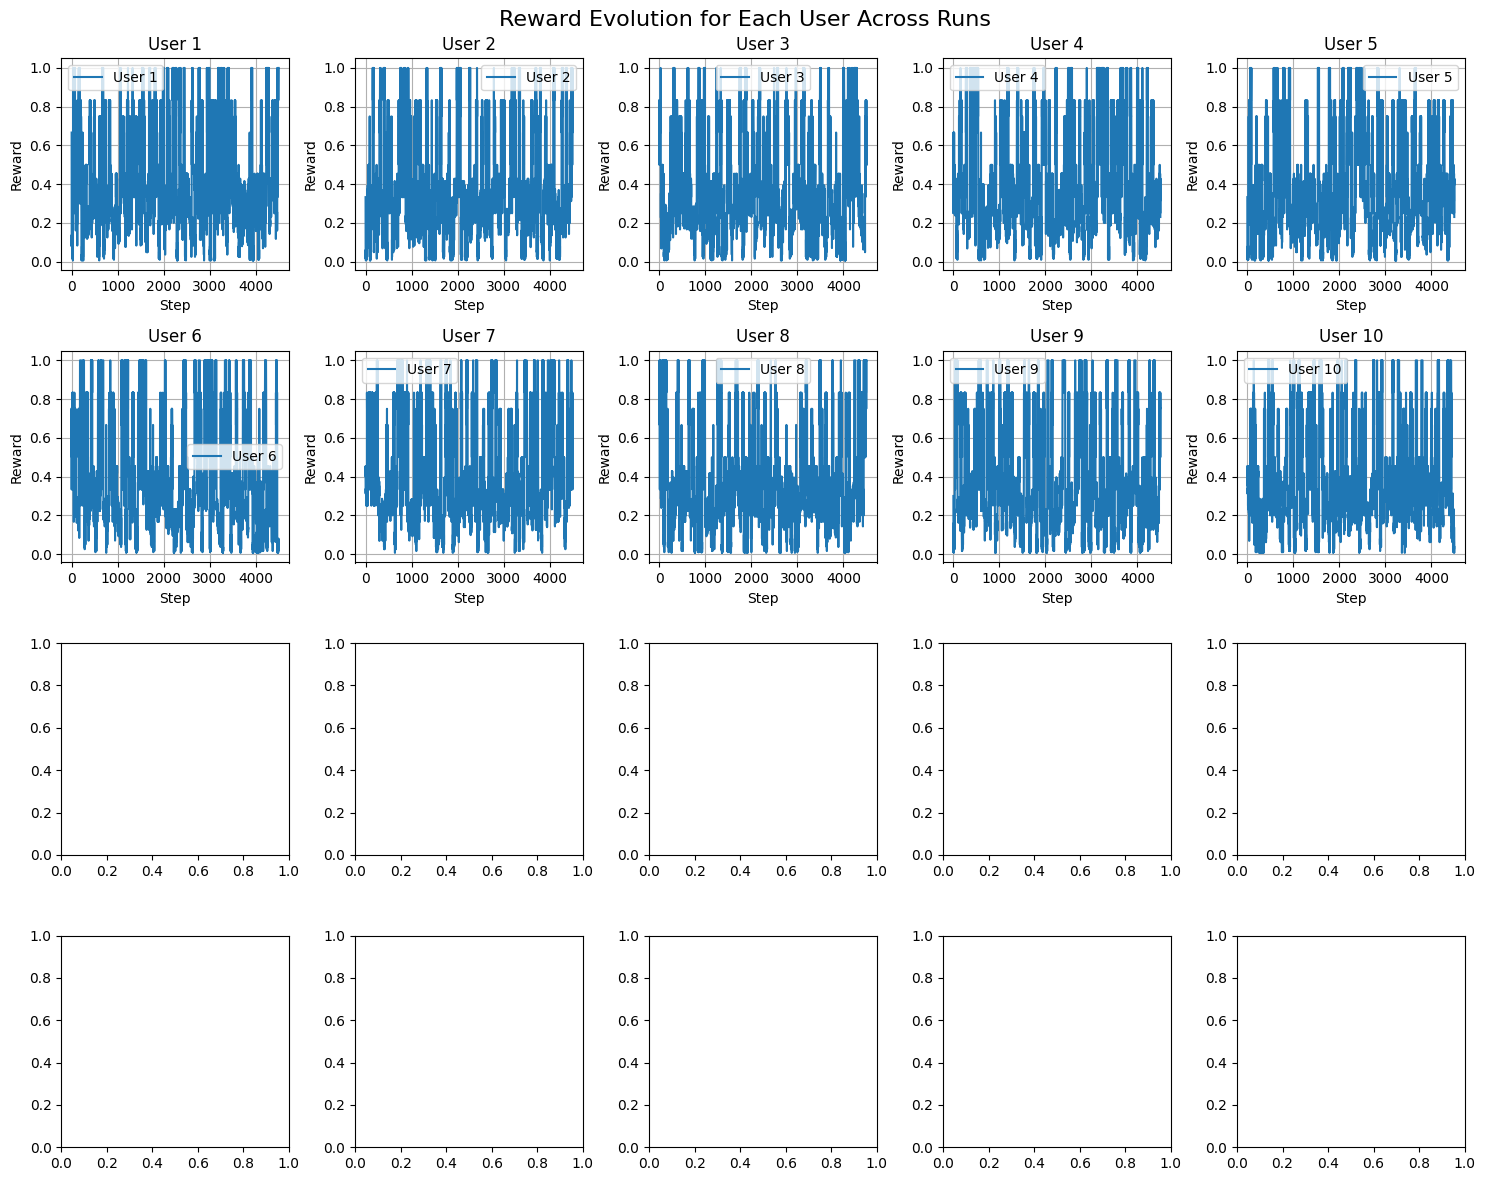

In [ ]:
plot_reward(rewards)

Plot average_throughput per user and fairness

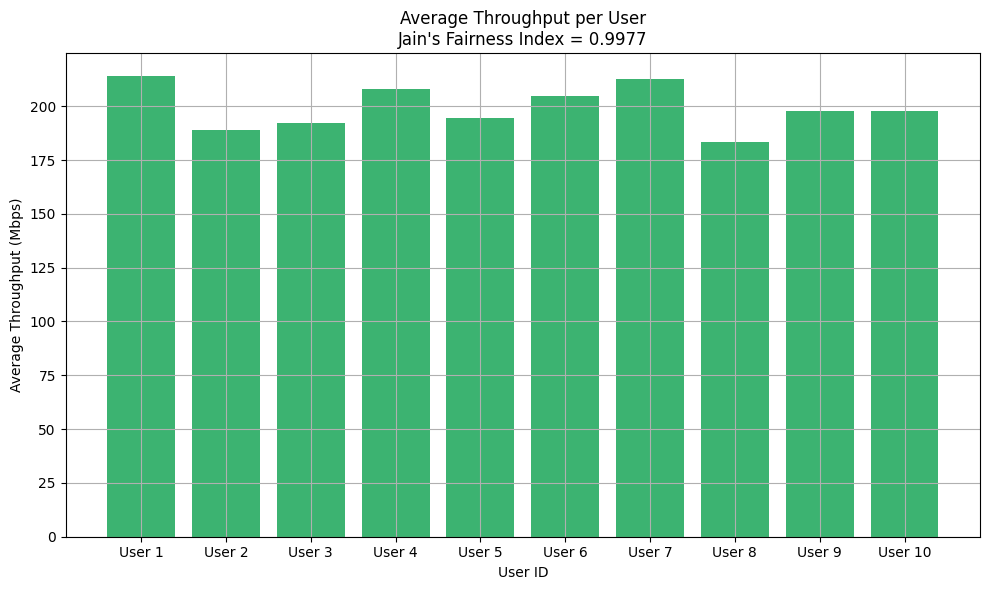

In [ ]:
throughput_buffer = [
    [reward * rat_env.max_thr for reward in rewards]
    for rewards in rewards
]

# Step 3: Compute average throughput per user
n_users = len(throughput_buffer[0])
avg_throughput_per_user = [
    np.mean([throughput_buffer[episode][user] for episode in range(len(throughput_buffer))])
    for user in range(n_users)
]

# Step 4: Compute Jain's fairness index
numerator = (sum(avg_throughput_per_user)) ** 2
denominator = n_users * sum(x ** 2 for x in avg_throughput_per_user)
jain_index = numerator / denominator if denominator != 0 else 0

# Step 5: Plot average throughput per user
plt.figure(figsize=(10, 6))
plt.bar(range(n_users), avg_throughput_per_user, color='mediumseagreen')
plt.xlabel('User ID')
plt.xticks(ticks=range(n_users), labels=[f'User {i+1}' for i in range(n_users)])
plt.ylabel('Average Throughput (Mbps)')
plt.title(f'Average Throughput per User\nJain\'s Fairness Index = {jain_index:.4f}')
plt.grid(True)
plt.tight_layout()
plt.show()

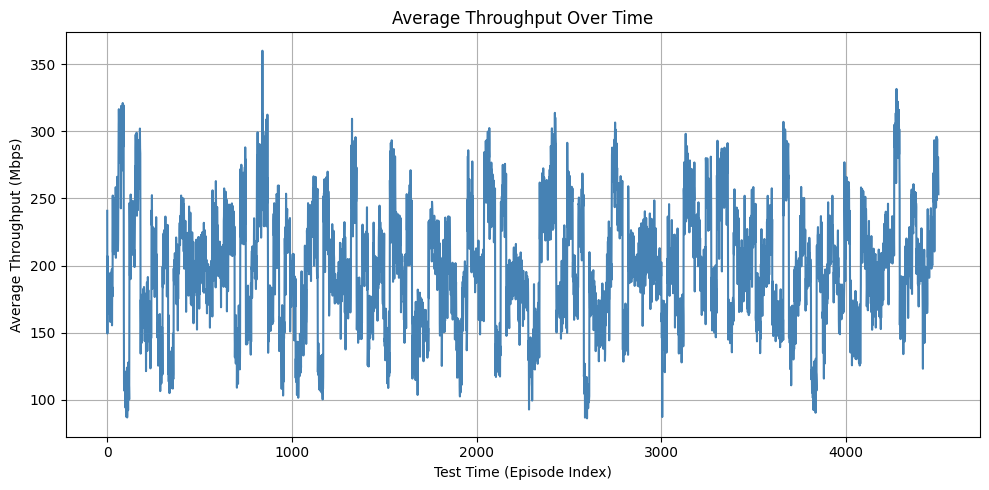

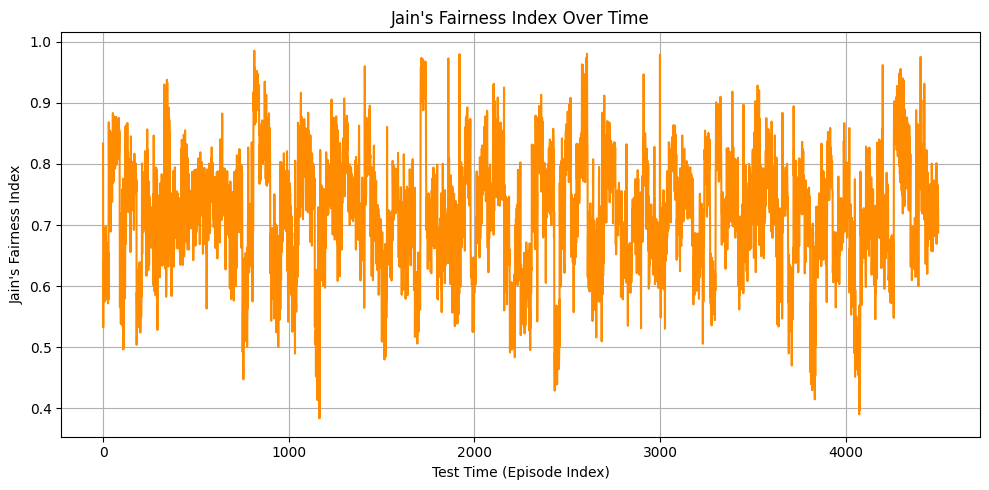

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Convert rewards to throughput
throughput_buffer = [
    [reward * rat_env.max_thr for reward in rewards]
    for rewards in rewards  # one list per episode
]

# Step 2: Track per-episode average throughput and Jain's fairness index
avg_throughput_over_time = []
jain_index_over_time = []

for episode in throughput_buffer:
    avg_thr = np.mean(episode)
    avg_throughput_over_time.append(avg_thr)

    numerator = (sum(episode)) ** 2
    denominator = len(episode) * sum(x ** 2 for x in episode)
    jain = numerator / denominator if denominator != 0 else 0
    jain_index_over_time.append(jain)

# Plot 1: Average Throughput Over Time
plt.figure(figsize=(10, 5))
plt.plot(avg_throughput_over_time, label="Avg Throughput", color='steelblue')
plt.xlabel('Test Time (Episode Index)')
plt.ylabel('Average Throughput (Mbps)')
plt.title('Average Throughput Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Jain's Fairness Index Over Time
plt.figure(figsize=(10, 5))
plt.plot(jain_index_over_time, label="Jain's Fairness Index", color='darkorange')
plt.xlabel('Test Time (Episode Index)')
plt.ylabel("Jain's Fairness Index")
plt.title("Jain's Fairness Index Over Time")
plt.grid(True)
plt.tight_layout()
plt.show()


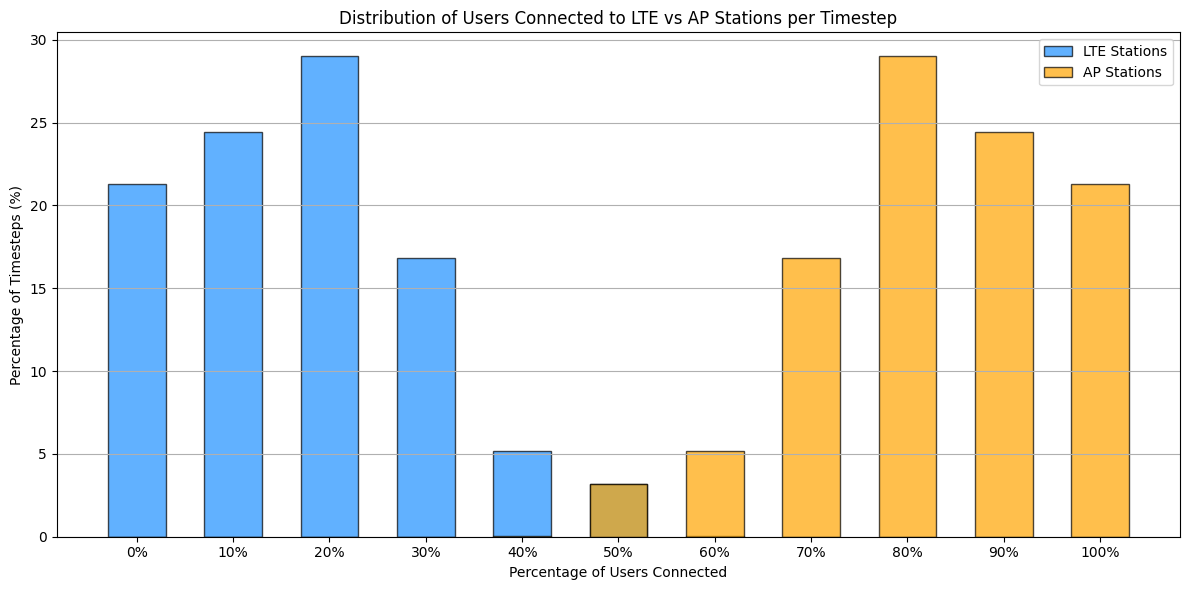

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

n_users = rat_env.n_users  # number of users
n_timesteps = len(actions)  # total timesteps

# Count users connected to LTE/AP per timestep
lte_counts_per_timestep = [sum(1 for a in action if a.item() <= 3) for action in actions]
ap_counts_per_timestep = [sum(1 for a in action if a.item() > 3) for action in actions]

# Count frequency of each number of users connected
lte_freq = Counter(lte_counts_per_timestep)
ap_freq = Counter(ap_counts_per_timestep)

# Prepare data for bar plot
x = np.arange(n_users + 1)  # from 0 to n_users

# Convert counts to percentage of timesteps
lte_percent = [(lte_freq.get(i, 0) / n_timesteps) * 100 for i in x]
ap_percent = [(ap_freq.get(i, 0) / n_timesteps) * 100 for i in x]

width = 0.6  # bar width

fig, ax = plt.subplots(figsize=(12, 6))

# Plot bars (same positions)
ax.bar(x, lte_percent, width, label='LTE Stations', color='dodgerblue', alpha=0.7, edgecolor='black')
ax.bar(x, ap_percent, width, label='AP Stations', color='orange', alpha=0.7, edgecolor='black')

# Set x-ticks as percentages from 0% to 100%
xtick_positions = np.arange(0, n_users + 1, max(1, n_users // 10))  # ticks at reasonable intervals
xtick_labels = [f"{int((pos / n_users) * 100)}%" for pos in xtick_positions]

ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels)

# Labeling
ax.set_xlabel('Percentage of Users Connected')
ax.set_ylabel('Percentage of Timesteps (%)')
ax.set_title('Distribution of Users Connected to LTE vs AP Stations per Timestep')
ax.legend()
ax.grid(axis='y')

plt.tight_layout()
plt.show()


Analyse Congestion: Percentage of Users in the same station

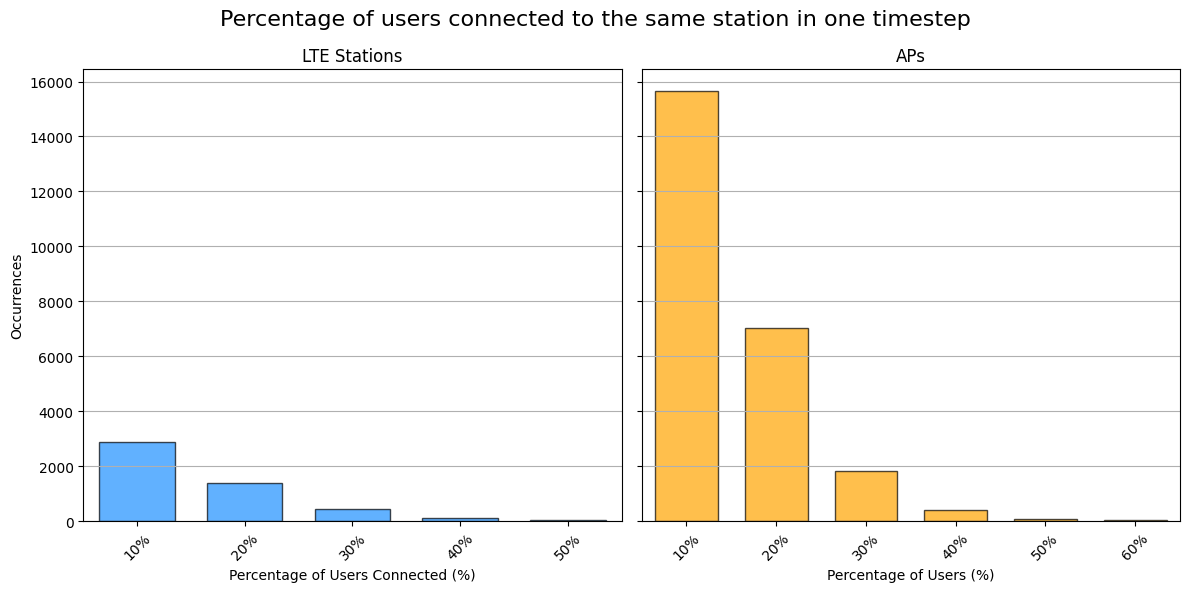

In [ ]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

n_users = rat_env.n_users  # total users

lte_station_ids = list(range(rat_env.n_ltesn))
ap_station_ids = list(range(rat_env.n_ltesn, rat_env.n_stations))

lte_percentages = []
ap_percentages = []

for action in actions:
    station_counts = Counter(a.item() for a in action)

    for st_id in lte_station_ids:
        count = station_counts.get(st_id, 0)
        percent = (count / n_users) * 100
        lte_percentages.append(percent)

    for st_id in ap_station_ids:
        count = station_counts.get(st_id, 0)
        percent = (count / n_users) * 100
        ap_percentages.append(percent)

def freq_from_percentages(percent_list):
    rounded = [round(p, 1) for p in percent_list if p >= 10]  # exclude <10% as per tick request
    return Counter(rounded)

lte_freq = freq_from_percentages(lte_percentages)
ap_freq = freq_from_percentages(ap_percentages)

lte_x = sorted(lte_freq.keys())
lte_y = [lte_freq[k] for k in lte_x]

ap_x = sorted(ap_freq.keys())
ap_y = [ap_freq[k] for k in ap_x]

# Create positions for bars (evenly spaced)
lte_pos = np.arange(len(lte_x))
ap_pos = np.arange(len(ap_x))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

bar_width = 0.7  # wider bars

ax1.bar(lte_pos, lte_y, width=bar_width, color='dodgerblue', edgecolor='black', alpha=0.7)
ax1.set_title('LTE Stations')
ax1.set_xlabel('Percentage of Users Connected (%)')
ax1.set_ylabel('Occurrences')
ax1.set_xticks(lte_pos)
ax1.set_xticklabels([f"{int(x)}%" for x in lte_x], rotation=45)
ax1.set_xlim(-0.5, len(lte_x) - 0.5)
ax1.grid(axis='y')

ax2.bar(ap_pos, ap_y, width=bar_width, color='orange', edgecolor='black', alpha=0.7)
ax2.set_title('APs')
ax2.set_xlabel('Percentage of Users (%)')
ax2.set_xticks(ap_pos)
ax2.set_xticklabels([f"{int(x)}%" for x in ap_x], rotation=45)
ax2.set_xlim(-0.5, len(ap_x) - 0.5)
ax2.grid(axis='y')

plt.suptitle('Percentage of users connected to the same station in one timestep', fontsize=16)
plt.tight_layout()
plt.show()


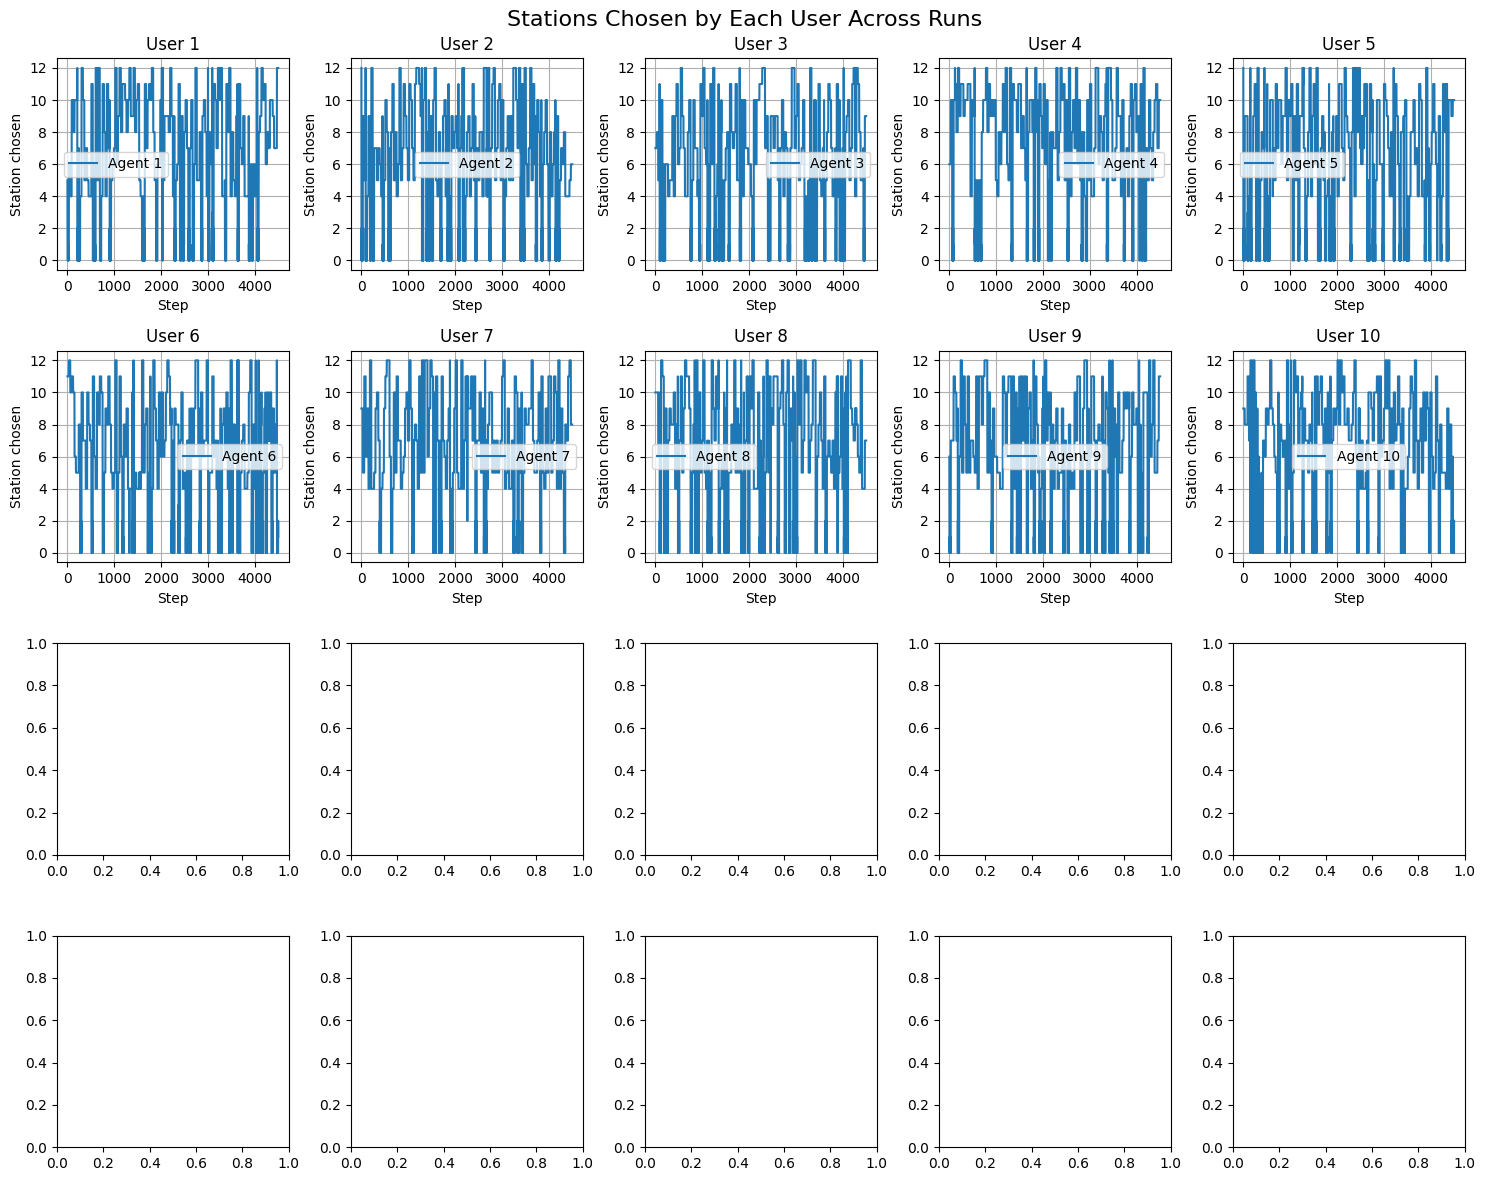

In [ ]:
plot_actions(actions)